## Requirements

In [1]:
# If missing, please install
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from scipy.stats import spearmanr
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

## Read data, print shapes and info

In [2]:
# Read data
monthly = pd.read_csv("data_monthly.csv")
weekly = pd.read_csv("data_weekly.csv")

In [3]:
# Parse dates to other format
weekly['Date'] = pd.to_datetime(weekly['Date'],errors="coerce")
monthly['Date'] = pd.to_datetime(monthly['Date'],errors="coerce")

In [4]:
print(monthly.shape)
print(monthly.info())

(36, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          36 non-null     datetime64[ns]
 1   unemployment  36 non-null     float64       
 2   tourists      36 non-null     int64         
 3   gdp           36 non-null     float64       
 4   confidence    36 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 1.5 KB
None


In [5]:
print(weekly.shape)
print(weekly.info())

(117, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      117 non-null    datetime64[ns]
 1   investment_tv             117 non-null    float64       
 2   investment_radio          117 non-null    float64       
 3   investment_press          117 non-null    float64       
 4   investment_banners        117 non-null    float64       
 5   investment_online         117 non-null    float64       
 6   stores_opened             117 non-null    int64         
 7   economy_index             117 non-null    float64       
 8   investment_competition    117 non-null    float64       
 9   public_holidays           117 non-null    int64         
 10  brand_knowledge           117 non-null    float64       
 11  christmas_dummy           117 non-null    int64         
 12  weather_inde

## 2. Join weekly and monthly data

Yes, it is possible, a way how to do it is explained in the next function

In [6]:
def from_weekly_to_monthly(weekly):
    # Provide ratio of how many days in week are from next and current month 
    weekly["w_curr"] = np.where((weekly["Date"] + pd.offsets.MonthEnd(0) - weekly["Date"]).dt.days <= 7, 
                                (weekly["Date"] + pd.offsets.MonthEnd(0) - weekly["Date"]).dt.days / 7, 1.0)
    weekly["w_next"] = 1 - weekly["w_curr"]
    
    # Create another dataframe dropping current and next month, where add new column 'month'
    weekly_curr = weekly.drop(columns = ["w_next"])
    weekly_curr["month"] = weekly_curr["Date"].dt.to_period("M")
    weekly_next = weekly.drop(columns = ["w_curr"])
    weekly_next["month"] = weekly_next["Date"].dt.to_period("M") + 1
    
    # Combine these two dataframes, where 'w_curr' and 'w_next' provide in the new column same column 'weight' 
    weekly_to_month = pd.concat([weekly_curr.rename(columns={"w_curr": "weight"}), weekly_next.rename(columns={"w_next": "weight"})])
    
    # Remove rows with zero weights and sort new dataframe
    weekly_to_month = weekly_to_month[weekly_to_month["weight"] > 0]
    weekly_to_month = (weekly_to_month.sort_values(["Date"]).reset_index(drop=True))
    
    # Provide arithemtic operation depends on colunm:
    #   * sum if the column describing money or holidays
    #   * avegare or mean if the column describing how many days store are open, indices, knowledge, recognitions,
    arithmetic_weekly_to_month = {'investment_tv': 'sum', 'investment_radio': 'sum', 'investment_press': 'sum', 'investment_banners': 'sum', 
                                  'investment_online': 'sum', 'investment_competition': 'sum', 'public_holidays': 'sum', 
                                  'investment_competition_1': 'sum', 'investment_competition_2': 'sum', 'sales': 'sum',
                                  'stores_opened': 'mean', 'economy_index': 'mean', 'brand_knowledge': 'mean', 'weather_index': 'mean', 
                                  'precipitation_index': "mean", 'competitor_recognition_1': 'mean', 'competitor_recognition_2': 'mean'}

    # For columns, which we need sum, we need provide ratio in specific weeks, which are splitted between two months
    for key in arithmetic_weekly_to_month.keys():
        if arithmetic_weekly_to_month[key] == 'sum':
            weekly_to_month[key] = weekly_to_month[key]*weekly_to_month['weight']

    # Group weekly data accoridng months and provide arithmetic opration depeds on the column
    monthly = (weekly_to_month[['month'] + list(arithmetic_weekly_to_month.keys())]
               .groupby("month", as_index=False).agg(arithmetic_weekly_to_month))
    
    return monthly    

In [7]:
# Add 'month' column to monthly data
monthly["month"] = monthly["Date"].dt.to_period("M")

# Merge monthly and new monthly data from weekly data 
monthly = pd.merge(monthly, from_weekly_to_monthly(weekly), on="month", how="inner")

print(monthly.shape)
print(monthly.info())

(27, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      27 non-null     datetime64[ns]
 1   unemployment              27 non-null     float64       
 2   tourists                  27 non-null     int64         
 3   gdp                       27 non-null     float64       
 4   confidence                27 non-null     float64       
 5   month                     27 non-null     period[M]     
 6   investment_tv             27 non-null     float64       
 7   investment_radio          27 non-null     float64       
 8   investment_press          27 non-null     float64       
 9   investment_banners        27 non-null     float64       
 10  investment_online         27 non-null     float64       
 11  investment_competition    27 non-null     float64       
 12  public_holidays

## 1. Overview of client’s business

In [8]:
fontsize = 13
def millions_formatter(x, pos):
    return f"{x/1_000_000:.1f}"

def thousands_formatter(x, pos):
    return f"{x/1_000:.1f}"

def ones_formatter(x, pos):
    return f"{x/1:.2f}"

def plot(vars, var_labels, formatter, weekly = weekly, y_label = 'Money [millions CZK]'):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    # plot variables
    for var, var_label in zip(vars, var_labels):
        axes.plot(weekly['Date'].values, weekly[var].values, label = var_label)
    
    # Add legend
    axes.legend(fontsize = fontsize)

    # Set axis labels for both axes
    axes.set_xlabel("Months", fontsize = fontsize)
    axes.set_ylabel(y_label, fontsize = fontsize)

    # Set same size of text for ticks
    axes.tick_params(axis='both', which='major', labelsize=fontsize)
    axes.tick_params(axis='both', which='minor', labelsize=fontsize)

    # Formatter for y axis
    axes.yaxis.set_major_formatter(FuncFormatter(formatter))
    axes.yaxis.get_offset_text().set_visible(False)

    # Set properties for nice plotting
    axes.margins(x=0.01, y=0.01)
    axes.grid(True)
    fig.tight_layout() 
    
# Transform percents to ratio in range [0,1]
weekly['weather_index'] = weekly['weather_index']/100

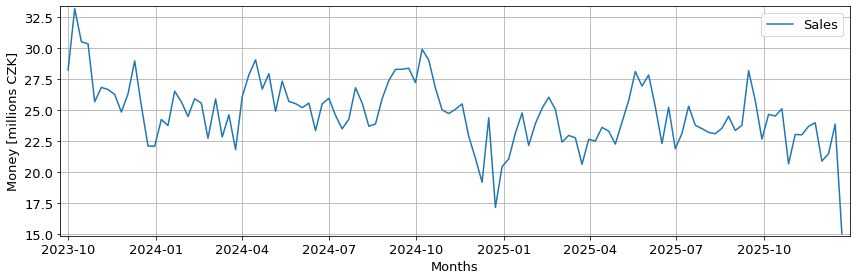

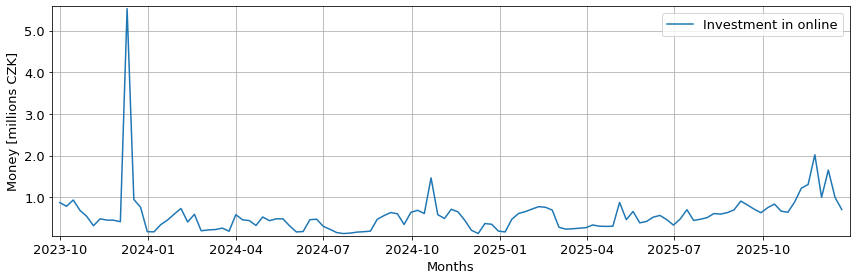

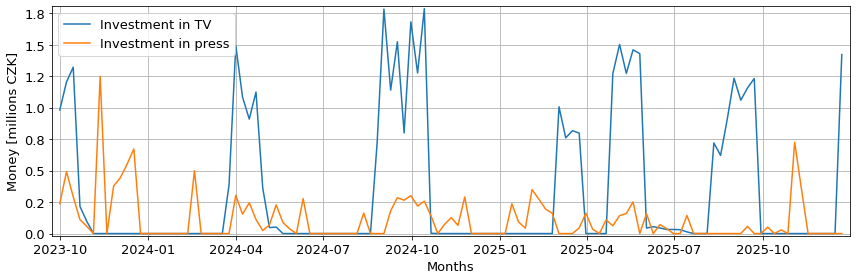

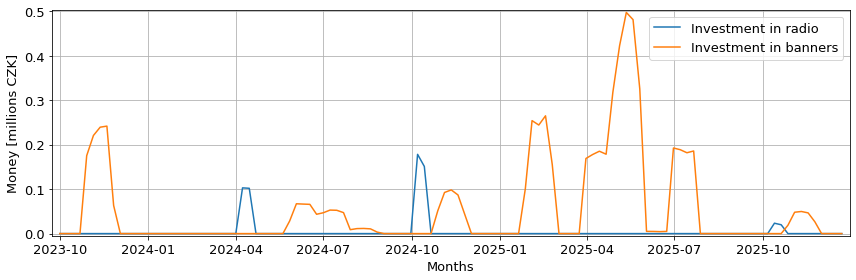

In [9]:
plot(['sales'], ['Sales'], millions_formatter)
plot(['investment_online'], ['Investment in online'], millions_formatter)
plot(['investment_tv', 'investment_press'], ['Investment in TV', 'Investment in press'], millions_formatter)
plot(['investment_radio', 'investment_banners'], ['Investment in radio', 'Investment in banners'], millions_formatter)

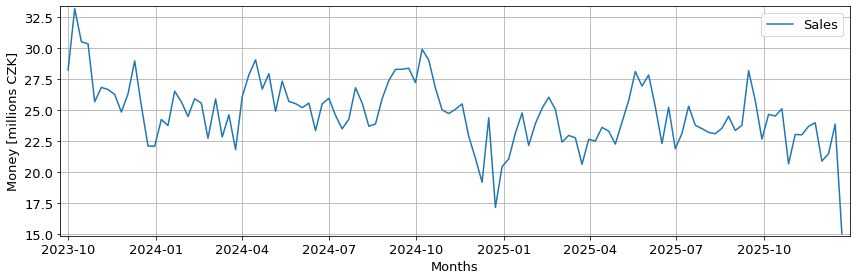

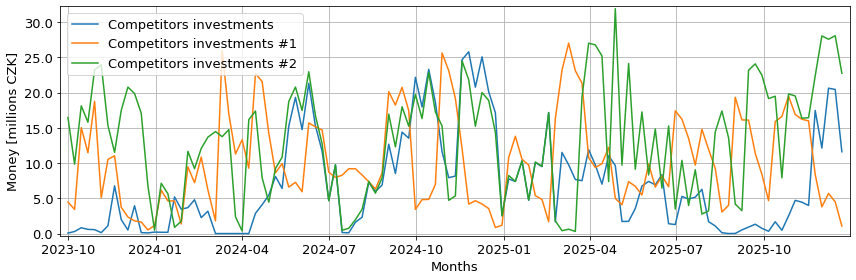

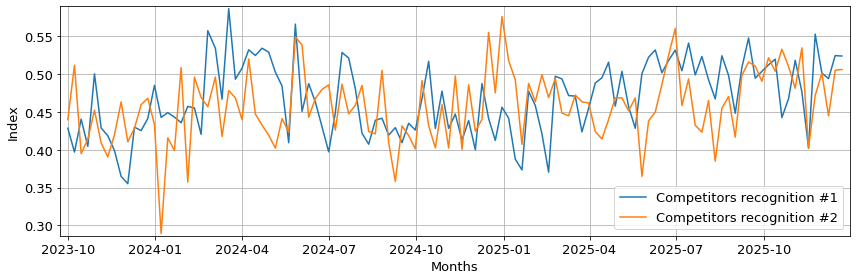

In [10]:
plot(['sales'], ['Sales'], millions_formatter)
plot(['investment_competition', 'investment_competition_1', 'investment_competition_2'], 
     ['Competitors investments', 'Competitors investments #1', 'Competitors investments #2'], millions_formatter)
plot(['competitor_recognition_1', 'competitor_recognition_2'], 
     ['Competitors recognition #1', 'Competitors recognition #2'], ones_formatter, y_label = 'Index')

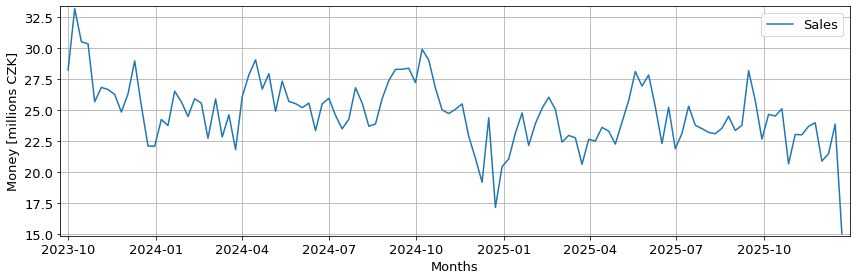

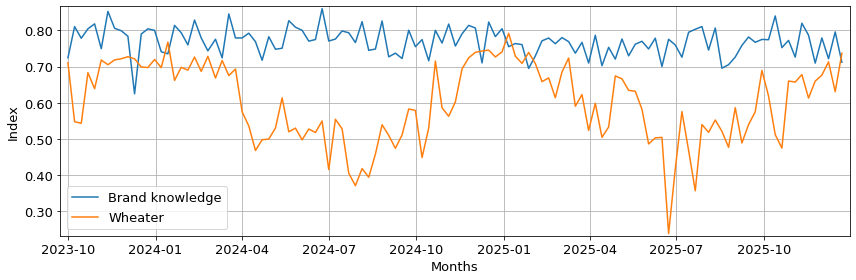

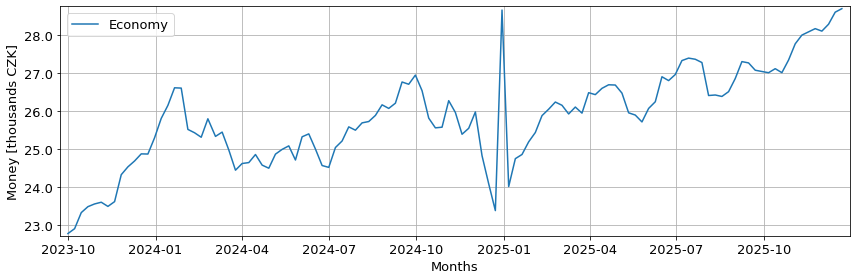

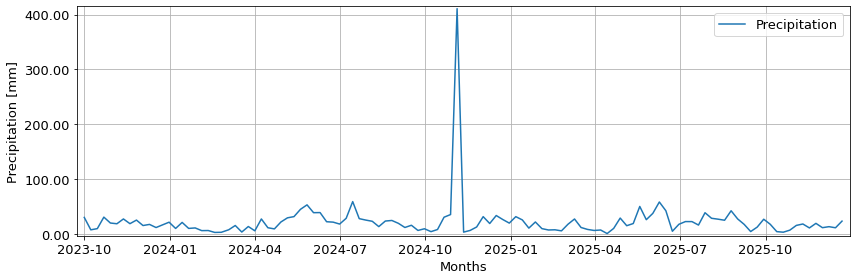

In [11]:
plot(['sales'], ['Sales'], millions_formatter)
plot(['brand_knowledge', 'weather_index'], ['Brand knowledge', 'Wheater'], ones_formatter, y_label = 'Index')
plot(['economy_index'], ['Economy'], thousands_formatter, y_label = 'Money [thousands CZK]')
plot(['precipitation_index'], ['Precipitation'], ones_formatter, y_label = 'Precipitation [mm]')

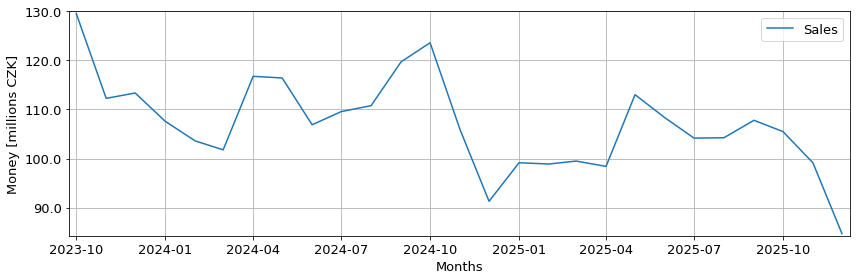

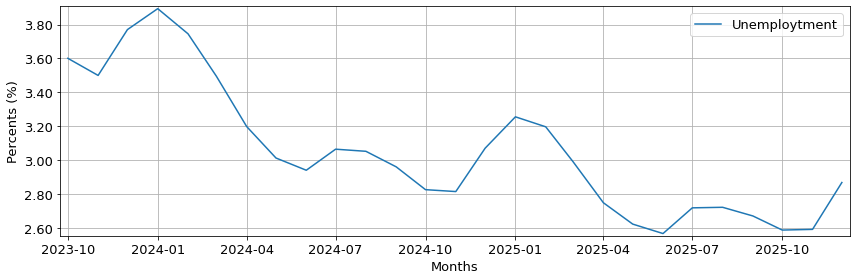

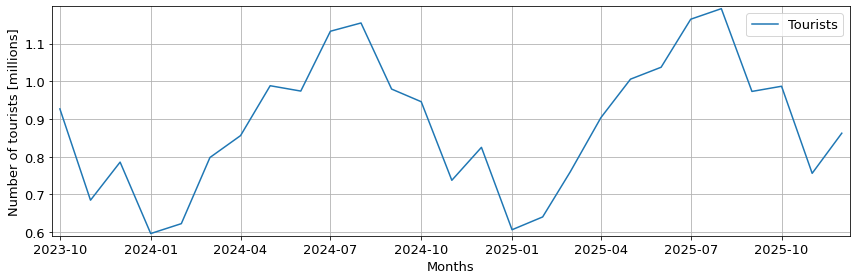

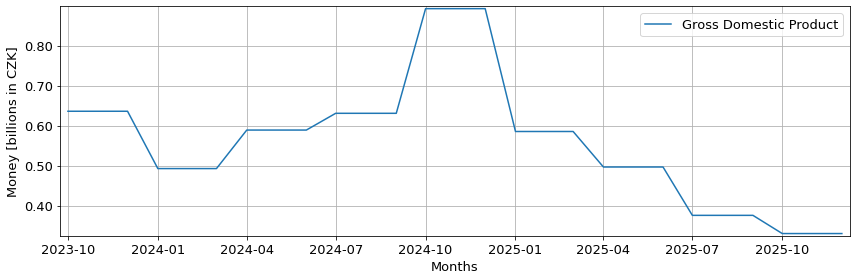

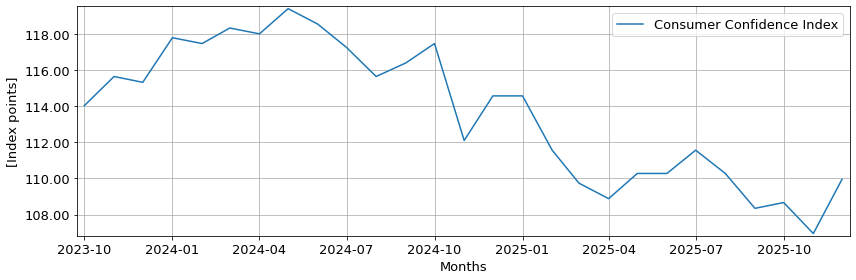

In [12]:
plot(['sales'], ['Sales'], millions_formatter, weekly = monthly)
plot(['unemployment'], ['Unemploytment'], ones_formatter, weekly = monthly, y_label = 'Percents (%)')
plot(['tourists'], ['Tourists'], millions_formatter, weekly = monthly, y_label = 'Number of tourists [millions]')
plot(['gdp'], ['Gross Domestic Product'], ones_formatter, weekly = monthly, y_label = 'Money [billions in CZK]')
plot(['confidence'], ['Consumer Confidence Index'], ones_formatter, weekly = monthly, y_label = '[Index points]')

## 3. Pre-selection
Strategy:
  * Check correlation
  * Check feature of importance in regression fit by machine learning model (xgboost) 

### Correlation

In [13]:
def plot_correlations(corr_sales):
    # Set color map for correlations
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(-1.0, 1.0)
    colors = cmap(norm(corr_sales[1:]))

    # Plot correlations as vertical bar plot 
    fig, axes = plt.subplots(figsize=(8, 8))
    axes.barh(corr_sales[1:].index, corr_sales[1:].values, color=colors)

    # Set axis labels for both axes
    axes.set_xlabel("Correlation to sales", fontsize=fontsize)

    # Set same size of text for ticks
    axes.tick_params(axis='both', which='major', labelsize=fontsize)
    axes.tick_params(axis='both', which='minor', labelsize=fontsize)

    # The highest at the top
    axes.invert_yaxis()

    # Set properties for nice plotting
    axes.margins(x=0.01, y=0.01)

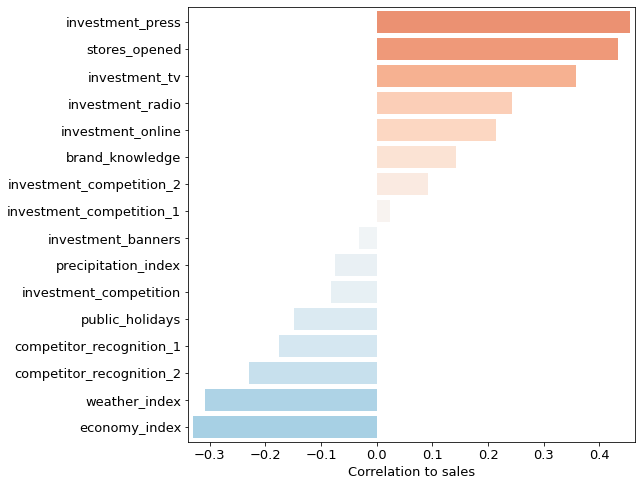

In [14]:
# Compute correlations in dataset, sort from positive to negative and plot
corr = weekly.drop(columns = ["Date", "w_curr", "YearWeek", "w_next", "christmas_dummy"]).corr(method="spearman")
corr_sales = corr['sales'].sort_values(ascending=False)
plot_correlations(corr_sales)

#### Discussion of correlation in weekly data:
* Maybe columns as 'investments_competition_2', 'investments_competition_1', 'investments_banners', 'precipation_index' can be removed from analysis

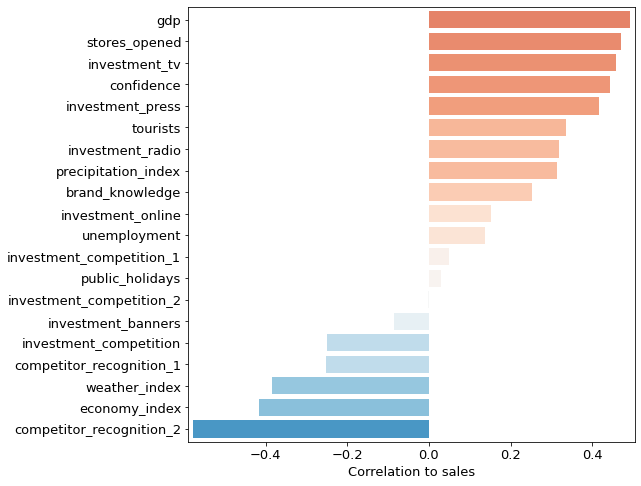

In [15]:
# Compute correlations in dataset, sort from positive to negative and plot
corr = monthly.drop(columns = ["Date", "month"]).corr(method="spearman")
corr_sales = corr['sales'].sort_values(ascending=False)
plot_correlations(corr_sales)

#### Discussion correlation in monthly data:
* Maybe columns as 'investments_competition_2', 'investments_competition_1', 'investments_banners', 'public_holidays' can be removed from analysis

### Regression by machine learning model (xgboost) with checking feature of importance

In [16]:
# Define residual, parity plots and ML model to estimate feature importance
def residual_plot(y_test, y_pred):
    plt.figure(figsize=(6,6))
    # Define residuals
    residuals = y_test - y_pred
    # Plot them with predicted values
    plt.scatter(y_pred, residuals)
    
    # Plot line to show expectations
    plt.axhline(0, color='red')
    
    # Set axis labels
    plt.xlabel("Predicted values [millions CZK]", fontsize=fontsize)
    plt.ylabel("Residuals [millions CZK]", fontsize=fontsize)
    
    # Set axis ticks font sizes
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # Set formatters for both axes
    ax = plt.gca() 
    ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax.yaxis.get_offset_text().set_visible(False)
    ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax.xaxis.get_offset_text().set_visible(False)
    ax.grid(True)
    
def parity_plot(y_test, y_pred):
    plt.figure(figsize=(6,6))
    
    # Plot tested and predicted values
    plt.scatter(y_test, y_pred, alpha=0.3)
    
    # Plot line to show expectations
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    
    # Set axis labels
    plt.xlabel("Expected values [millions CZK]", fontsize=fontsize)
    plt.ylabel("Predicted values [millions CZK]", fontsize=fontsize)
    
    # Set title with R2 and RMSE
    plt.title(f"Parity Plot (R² = {r2_score(y_test, y_pred):.3f}, RMSE = {mean_squared_error(y_test, y_pred):.3f})", fontsize=fontsize)
    
    # Set axis ticks font sizes
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # Set formatters for both axes
    ax = plt.gca() 
    ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax.yaxis.get_offset_text().set_visible(False)
    ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax.xaxis.get_offset_text().set_visible(False)
    ax.grid(True)
    
def apply_XGBRegressor(X_train, y_train, X_test, y_test):
    # Set ML model to train
    model = XGBRegressor(booster="gbtree")
    
    # Fit model using training dataset
    model.fit(X_train, y_train)
    
    # Predict values for testing dataset
    y_pred = model.predict(X_test)

    # Provide feature importance
    importances = model.get_booster().get_score(importance_type='weight')

    # Transform feature importance to dataframe, sort it and normalize
    importance_xgb = pd.DataFrame(importances.items(), columns=['feature', 'importance_xgb'])
    importance_xgb = importance_xgb.sort_values(by='importance_xgb', ascending=False)
    importance_xgb['importance_xgb_norm'] = importance_xgb['importance_xgb'] / sum(importance_xgb['importance_xgb'])

    # Set colors for bars
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(-1, 1)
    colors = cmap(norm(-0.33))
    
    # Plot feature importance to bar plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.barh(importance_xgb['feature'], importance_xgb['importance_xgb_norm'], color=colors)
    
    # Set axis labels
    ax.set_xlabel("Importance to sales", fontsize=fontsize)
    
    # The highest at the top
    ax.invert_yaxis()
    
    # Set axis ticks font sizes
    plt.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # Set properties for nice plotting
    ax.margins(x=0.01, y=0.01)
    
    return y_test, y_pred

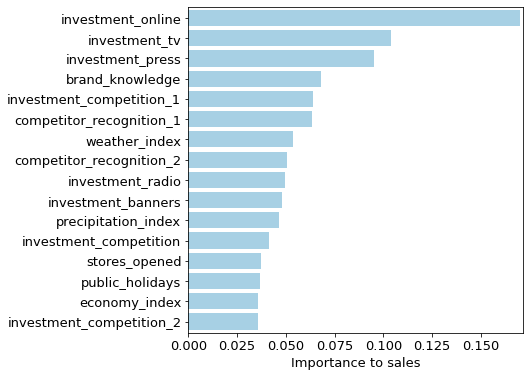

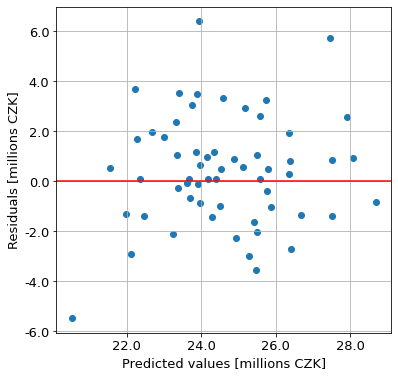

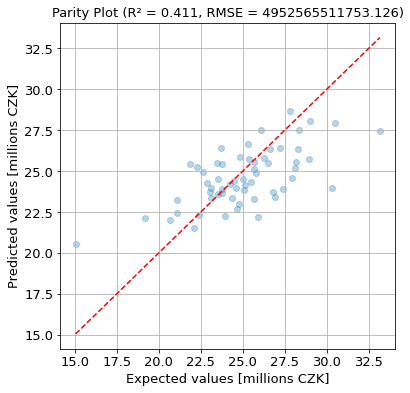

In [17]:
# Select data for training and testing
X = weekly.drop(columns = ["Date", "sales", "w_curr", "YearWeek", "w_next", "christmas_dummy"])
y = weekly["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Train model, provide simple checks to understand performance of the model
y_test, y_pred = apply_XGBRegressor(X_train, y_train, X_test, y_test)
residual_plot(y_test, y_pred)
parity_plot(y_test, y_pred)

#### Discussion:
* Low importance was found for 'investments_competition_2', 'economy_index', 'public_holidays', 'stores_open'

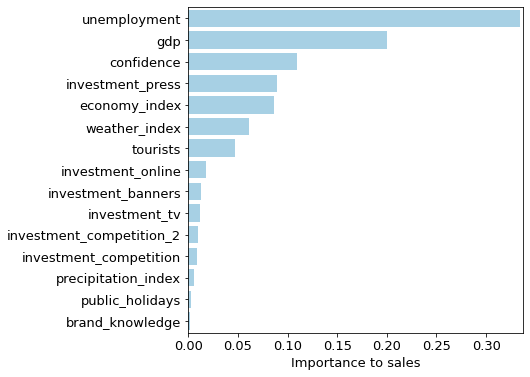

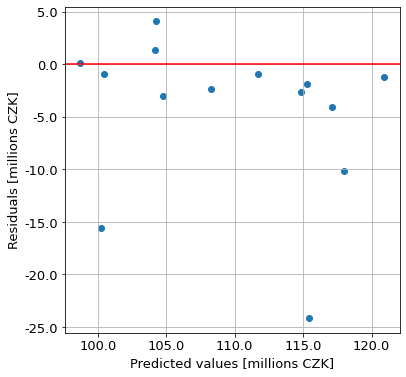

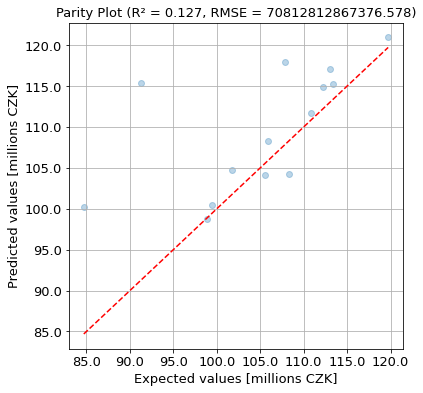

In [18]:
# select data for training and testing
X = monthly.drop(columns = ["Date", "sales", "month"])
y = monthly["sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

y_test, y_pred = apply_XGBRegressor(X_train, y_train, X_test, y_test)
residual_plot(y_test, y_pred)
parity_plot(y_test, y_pred)

#### Discussion :
* Low importance was found for 'brand_knowledge', 'public_holidays', 'precipation_index', 'investments_competition'

### 5. Apply pre-selection to dataset
I did some checks, but I am not sure if it is relevant enough to remove any column from final model. I will keep all variables (columns), later I will discuss whetever any variables is could be reduced.

### 4. Variables (columns) format
In my understanding, there is no reason to apply any correction to variables or columns to be ready for final model

In [19]:
# For sure, sort dataframes according time
weekly = weekly.sort_values("Date").reset_index(drop=True)
monthly = monthly.sort_values("month").reset_index(drop=True)

### 6. Behavioral findings using diminishing returns and influencing ads immediately with memory
* For diminishing returns we are using Hill or S-curve:
\begin{equation*}
f(x) = \frac{x^{\gamma}}{x^{\gamma}+k^{\gamma}}
\end{equation*}

* For ads memory we are using "decay law":
\begin{equation*}
x(t) = \mathrm{Investments}(t) + \lambda \cdot x(t-1), \mathrm{where} \ 0 \ \leq \ \lambda \ \leq \ 1 
\end{equation*}

In [20]:
def diminishingReturns(x, k, gamma):
    return (x ** gamma) / (x ** gamma + k ** gamma)

def adsMemory(series, lambda_):
    result = np.zeros(len(series))
    for t in range(len(series)):
        result[t] = series.iloc[t] + (lambda_ * result[t-1] if t > 0 else 0)
    return result

In [21]:
def extractPercentileFromNonZeroRows(series):
    series_without_zeros = series[series > 0]
    if len(series_without_zeros) > 0:
        alpha = np.percentile(series_without_zeros, 70)
    else:
        alpha = 1.0
    return alpha

In [22]:
# Estimate parameters of functions from data
channels = ["investment_tv", "investment_radio", 
            "investment_press", "investment_banners", "investment_online"]
adsMemory_params_weekly = {}
diminishingReturns_params_weekly = {}
adsMemory_params_monthly = {}
diminishingReturns_params_monthly = {}

for channel in channels:
    # "gamma" is proportional to median spend 
    alpha_weekly = extractPercentileFromNonZeroRows(weekly[channel])
    alpha_monthly = extractPercentileFromNonZeroRows(monthly[channel])
    # "k" is proportional to variance
    k_weekly = 1 + np.log10(weekly[channel].std() + 1)
    k_monthly = 1 + np.log10(monthly[channel].std() + 1)
    diminishingReturns_params_weekly[channel+'_adsMemory'] = (alpha_weekly, k_weekly)
    diminishingReturns_params_monthly[channel+'_adsMemory'] = (alpha_monthly, k_monthly)    
    
    # Estimate how series are correlated with itself
    autocorr_weekly = weekly[channel].autocorr(lag=1)
    autocorr_monthly = monthly[channel].autocorr(lag=1)
    # Apply correlation as lambda
    adsMemory_params_weekly[channel] = min(max(autocorr_weekly, 0.05), 0.9)
    adsMemory_params_monthly[channel] = min(max(autocorr_monthly, 0.05), 0.9)

In [23]:
# Apply ads memory into dataset
for channel, decay in adsMemory_params_weekly.items():
    weekly[f"{channel}_adsMemory"] = adsMemory(weekly[channel], decay)
for channel, decay in adsMemory_params_monthly.items():
    monthly[f"{channel}_adsMemory"] = adsMemory(monthly[channel], decay)

In [24]:
# Apply diminishing returns into dataset
for channel, (k, gamma) in diminishingReturns_params_weekly.items():
    weekly[f"{channel}_diminishingReturns"] = diminishingReturns(weekly[channel], k, gamma)
for channel, (k, gamma) in diminishingReturns_params_monthly.items():
    monthly[f"{channel}_diminishingReturns"] = diminishingReturns(monthly[channel], k, gamma)

### 7. Building a marketing mix model(s)
I prepared two models based on weekly and monthly datasets.
Probably, there could be some variables which will behave differently in these models.
Otherwise the monthly model can be as a proof for same observations in weekly model (as control model).

In [25]:
# Add constants to datasets
weekly['constant'] = 1.0
monthly['constant'] = 1.0

In [26]:
# Set variables to build a model
weekly_model_vars = [
    "investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
    "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
    "investment_online_adsMemory_diminishingReturns",
    "investment_competition", "investment_competition_1", "investment_competition_2", "competitor_recognition_1", "competitor_recognition_2",
    "public_holidays", "stores_opened", "economy_index", "brand_knowledge", "weather_index", "precipitation_index", 
    "constant"]

In [27]:
# Fit Ordinary Least Squares (OLS) model and print model fit result
model_weekly = sm.OLS(weekly["sales"], weekly[weekly_model_vars]).fit()
print(model_weekly.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     17.79
Date:                Thu, 22 Jan 2026   Prob (F-statistic):           1.88e-22
Time:                        01:07:15   Log-Likelihood:                -1816.3
No. Observations:                 117   AIC:                             3667.
Df Residuals:                     100   BIC:                             3714.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### 8-A. Comments to weekly model
#### Marketing:
Several variables (columns) look important (according p-value: (P > |t|) < 0.05):
* Investments - TV
* Investments - Press
* Investments - Online
* Public holidays
* Stores open
* Weather index
* Economy index
* Brand knowledge

#### Statistics
* From R-squared, 74% of sales is explained by model
* From Prob(F-statistics), the model is statistically significant (p < 0.01)
* From Prob(Ommibus) or Prob(Jarque-Bera), residuals looks normal (p > 0.05)
* From Durbin-Watson, residuals look independent (p ~ 2)
* From Conditional number, strong multicollinearity or numerical instability affects model

In [28]:
# Set variables to build a model
# Removing competitors investments and reconitions (becuase of their less importance) we improve monthly model
monthly_model_vars = [
    "investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
    "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
    "investment_online_adsMemory_diminishingReturns", 
    #"investment_competition", "investment_competition_1", "investment_competition_2", "competitor_recognition_1", "competitor_recognition_2",
    "public_holidays", "stores_opened", "economy_index", "brand_knowledge", "weather_index", "precipitation_index",
    "unemployment", "tourists", "gdp", "confidence", "constant"]

In [29]:
# Fit model and print model fit result
model_monthly = sm.OLS(monthly["sales"], monthly[monthly_model_vars]).fit()
print(model_monthly.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     5.814
Date:                Thu, 22 Jan 2026   Prob (F-statistic):            0.00276
Time:                        01:07:15   Log-Likelihood:                -442.25
No. Observations:                  27   AIC:                             916.5
Df Residuals:                      11   BIC:                             937.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

### 8-B. Comments to monthly model
Several variables (columns) look the most important (according p-value: (P > |t|) < 0.35):
* Economy index
* Investments - TV
* Weather index

#### Statistics
* From R-squared, 88.8% of sales is explained by model
* From Prob(F-statistics), the model is statistically significant (p < 0.01)
* From Prob(Ommibus) or Prob(Jarque-Bera), residuals looks normal (p > 0.05)
* From Durbin-Watson, residuals look independent (p ~ 2)
* From Conditional number, strong multicollinearity or numerical instability affects model

### 9. Model validation
Split dataset to fitting and validation parts. At first step, fit the first part and use first four weeks for validation. In the next step, remove earliest week, add four validation weeks into fitting part, provide fit and additional fours week use for validat. Repeat until end of dataset.

In [30]:
def plot_validation(values, errors, y_label, formatter):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4))
    
    # If empty errors use normal plottinf else errorbars
    if not errors.empty:
        axes.errorbar(values.index, values.values, yerr = errors, fmt ='o')
    else:
        axes.plot(values.index, values.values)

    # Set axis labels
    axes.set_xlabel("Validation iterations", fontsize = fontsize)
    axes.set_ylabel(y_label, fontsize = fontsize)

    # Set axis ticks font sizes
    axes.tick_params(axis='both', which='major', labelsize=fontsize)
    axes.tick_params(axis='both', which='minor', labelsize=fontsize)

    # Set formatter for y axis
    axes.yaxis.set_major_formatter(FuncFormatter(formatter))
    axes.yaxis.get_offset_text().set_visible(False)   

    # Set properties for nice plotting
    axes.grid(True)
    fig.tight_layout() 
    axes.margins(x=0.01, y=0.01)

#### 9A. Predictive power 
* Check root mean square error (RMSE) as function of validated months
* Check mean absolute percentage error (MAPE) as function of validated months
* Check mean absolute error (MAE) as function of validated months
* Check coefficient of determination ($\mathrm{R}^2$) as function of validated months

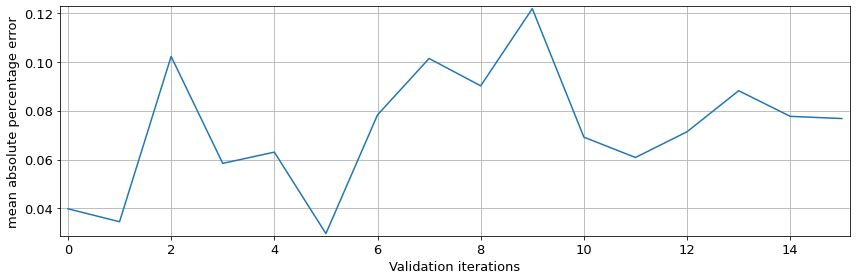

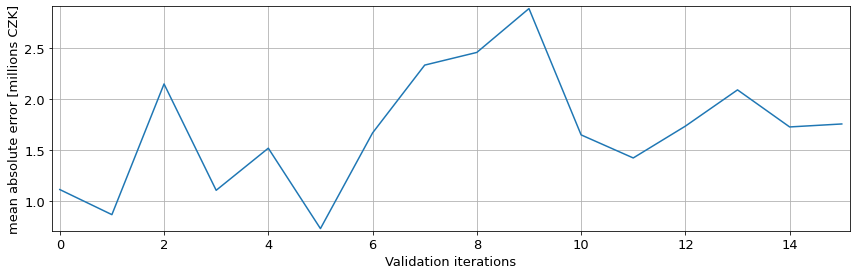

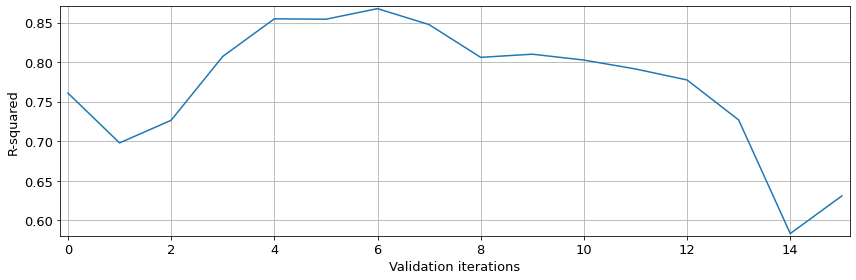

In [31]:
validation = []
# Loop over dataset to validate
for i in range(16):
    # Set fitting and validation datasets
    fit_weekly = weekly[0+i*4:52+i*4]
    validate_weekly = weekly[52+i*4:52+i*4+4]
    
    # Fit model using fitting dataset
    fit_model = sm.OLS(fit_weekly["sales"], fit_weekly[weekly_model_vars]).fit()
    
    # Validate model using validation dataset
    validate_weekly['predicted_sales'] = fit_model.predict(validate_weekly[weekly_model_vars])
    
    # Create dictionary with statistical variables
    dict_ = {}
    dict_['mape']   = mean_absolute_percentage_error(validate_weekly['sales'], validate_weekly['predicted_sales'])
    dict_['rmse']   = np.sqrt(mean_squared_error(validate_weekly['sales'], validate_weekly['predicted_sales']))
    dict_['mae']    = mean_absolute_error(validate_weekly['sales'], validate_weekly['predicted_sales'])
    dict_['r2']     = fit_model.rsquared
    dict_['adj_r2'] = fit_model.rsquared_adj
    
    # Append dictionary to list
    validation.append(dict_)

# Transform list to dataframe
validation = pd.DataFrame(validation)

# Plot validation results
plot_validation(validation['mape'], pd.Index([]), "mean absolute percentage error", ones_formatter)
plot_validation(validation['mae'], pd.Index([]), "mean absolute error [millions CZK]", millions_formatter)
plot_validation(validation['r2'], pd.Index([]), "R-squared", ones_formatter)

#### 9B. Stability of coefficients
* Check sign of coefficients as function of fitted interval
* Check magnitude of coefficients as function of fitted interval
* Check error of magnitudes as function of fitted interval

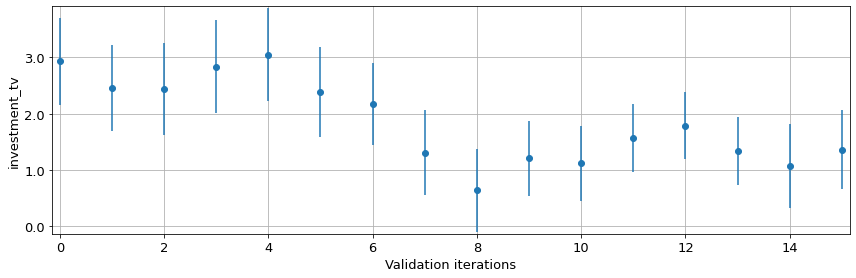

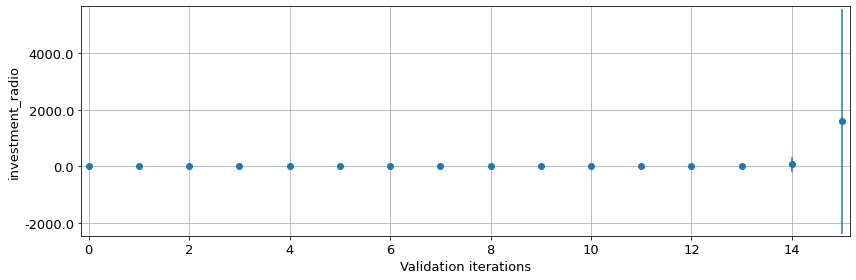

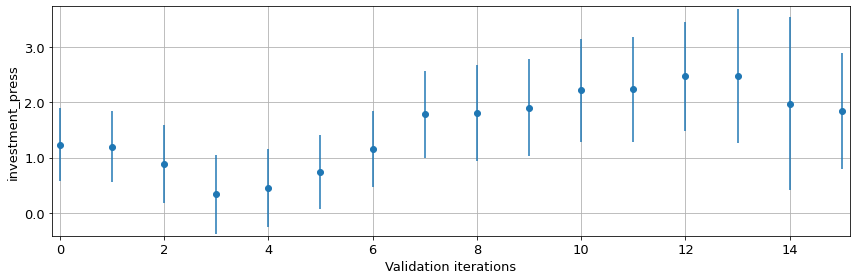

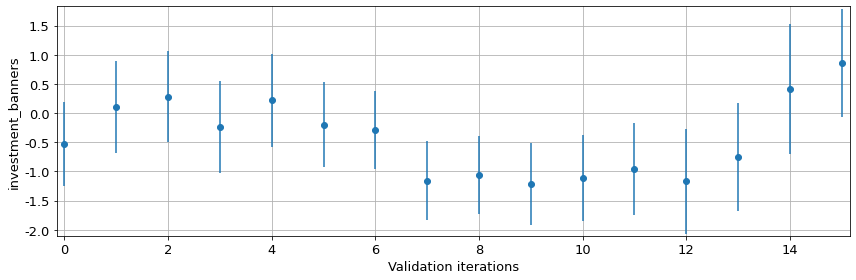

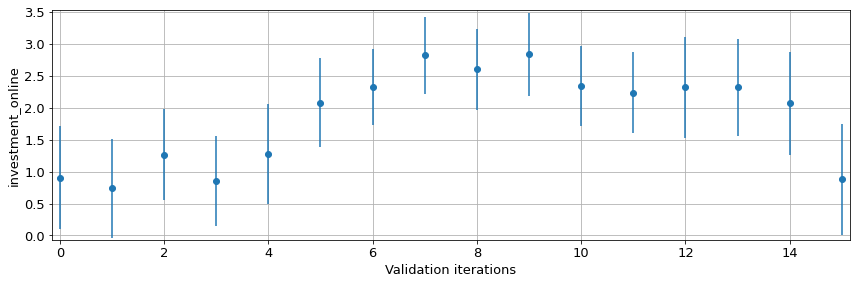

In [32]:
validation = []
# Loop over dataset to validate
for i in range(16):
    # Set fitting and validation datasets
    fit_weekly = weekly[0+i*4:52+i*4]
    validate_weekly = weekly[52+i*4:52+i*4+4]
    
    # Fit model using fitting dataset
    fit_model = sm.OLS(fit_weekly["sales"], fit_weekly[weekly_model_vars]).fit()

    # Create dictionaries exatracting values, its errrors, p-values and t-values of marketing channels for validation
    params = fit_model.params[["investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
                               "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
                               "investment_online_adsMemory_diminishingReturns"]]
    std_error = fit_model.bse[["investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
                               "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
                               "investment_online_adsMemory_diminishingReturns"]]
    t_value = fit_model.tvalues[["investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
                                 "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
                                 "investment_online_adsMemory_diminishingReturns"]]
    p_value = fit_model.pvalues[["investment_tv_adsMemory_diminishingReturns", "investment_radio_adsMemory_diminishingReturns", 
                                 "investment_press_adsMemory_diminishingReturns", "investment_banners_adsMemory_diminishingReturns", 
                                 "investment_online_adsMemory_diminishingReturns"]]
    
    # Replace keys in dictionaries
    params = {k.replace("_adsMemory_diminishingReturns", "_value"): v for k, v in params.items()}
    std_error = {k.replace("_adsMemory_diminishingReturns", "_error"): v for k, v in std_error.items()}
    t_value = {k.replace("_adsMemory_diminishingReturns", "_tvalue"): v for k, v in t_value.items()}
    p_value = {k.replace("_adsMemory_diminishingReturns", "_pvalue"): v for k, v in p_value.items()}
    
    # Append dictionaries to list
    validation.append({**params, **std_error, **t_value, **p_value})

# Transform list to dataframe
validation = pd.DataFrame(validation)

# Plot validation results
plot_validation(validation['investment_tv_value'], validation['investment_tv_error'], "investment_tv", millions_formatter)
plot_validation(validation['investment_radio_value'], validation['investment_radio_error'], "investment_radio", millions_formatter)
plot_validation(validation['investment_press_value'], validation['investment_press_error'], "investment_press", millions_formatter)
plot_validation(validation['investment_banners_value'], validation['investment_banners_error'], "investment_banners", millions_formatter)
plot_validation(validation['investment_online_value'], validation['investment_online_error'], "investment_online", millions_formatter)

#### 9C. Residual diagnostics
* Plot predicted values, fitted values and its residuals (very simple)

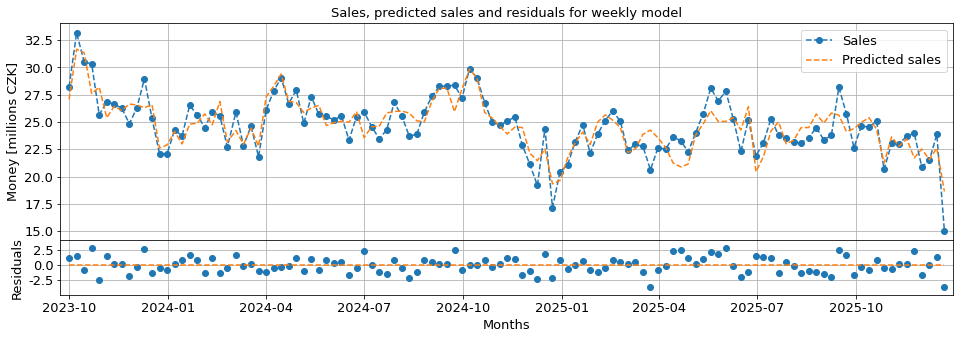

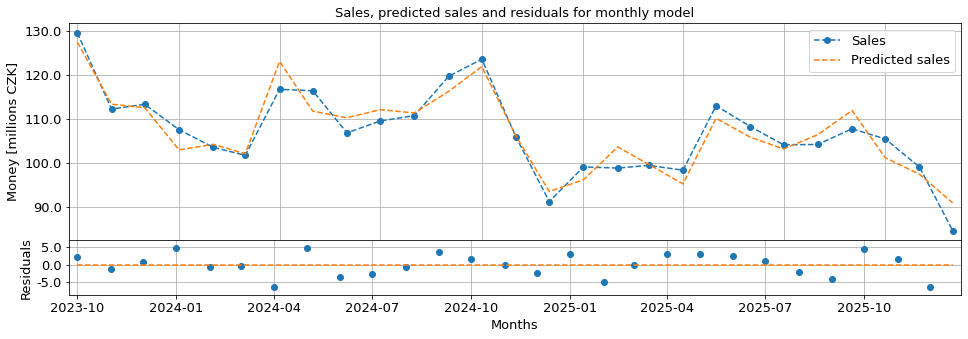

In [33]:
# Residual diagnostics
def plot_residuals(dataset, predicted_values, title):
    fig, axes = plt.subplots(2, 1, figsize=(16, 5), gridspec_kw={'height_ratios': [4, 1]})
    fig.subplots_adjust(hspace=0.0, wspace=0.)
    
    # Set title
    axes[0].set_title(title, size=fontsize)
    
    # Plot fitted values, predicted values and its residuals
    axes[0].plot(dataset['Date'].values, dataset['sales'].values, label = 'Sales', marker="o", linestyle='dashed', color='C0')
    axes[0].plot(dataset['Date'].values, predicted_values, label = 'Predicted sales', marker="", linestyle='dashed', color='C1')
    axes[1].plot(dataset['Date'].values, dataset['sales'].values - predicted_values, marker="o", linestyle="None", color='C0')
    
    # Plot line for better understand of residuals
    axes[1].hlines(0., weekly['Date'].values.min(), weekly['Date'].values.max(), linestyle='dashed', color='C1')
    
    # Add legend
    axes[0].legend(fontsize = fontsize)

    # Set axis labels 
    axes[1].set_xlabel("Months", fontsize = fontsize)
    axes[0].set_ylabel("Money [millions CZK]", fontsize = fontsize)
    axes[1].set_ylabel("Residuals", fontsize = fontsize)

    # Set axis ticks font sizes
    axes[0].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[0].tick_params(axis='both', which='minor', labelsize=fontsize)
    axes[1].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[1].tick_params(axis='both', which='minor', labelsize=fontsize)
    
    # Set formatter for y axis
    axes[0].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    axes[1].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    axes[0].yaxis.get_offset_text().set_visible(False)
    axes[1].yaxis.get_offset_text().set_visible(False)
    
    # Set properties for nice plotting
    axes[0].margins(x=0.01, y=0.05)
    axes[1].margins(x=0.01, y=0.20)
    axes[0].grid(True) 
    axes[1].grid(True)
    axes[0].set_xticklabels([]) 
    
plot_residuals(weekly, model_weekly.predict(weekly[weekly_model_vars]), "Sales, predicted sales and residuals for weekly model")
plot_residuals(monthly, model_monthly.predict(monthly[monthly_model_vars]), "Sales, predicted sales and residuals for monthly model")

#### 9D. Contribution plausibility
* Compare contribution of marketing channel in investments and sales
#### 9E. Behavioral sanity checks
* Check if diminishing returns is realistic (expert eye?)
* Check if add memory is realistic (expert eye?) 
#### 9F. Sensitivity analysis
* Remove one channel, refit and check result, any significant difference?
* Increase or decrease addMemory and diminishingReturns parameters about 10%

#### 11A. Channel contribution to sales

In [34]:
def plotContributionOrEfficiency(dictionary, label = "Contribution of investments on sales [%]", title = "Weekly model"):
    # Set colors for bars
    cmap = plt.cm.RdBu_r
    norm = plt.Normalize(-max(dictionary.values), max(dictionary.values))
    colors = cmap(norm(dictionary))

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.set_title(title, size=fontsize)
    
    # Plot marketing channels and its properties
    ax.barh([x.replace("_adsMemory_diminishingReturns", "") for x in list(dictionary.keys())], dictionary.values, color=colors)
    
    # Set axis labels
    ax.set_xlabel(label, fontsize=fontsize)

    # Set axis ticks font sizes
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=fontsize) 
    
    # The highest at the top
    ax.invert_yaxis()
    
    # Set properties for nice plotting
    ax.margins(x=0.01, y=0.01)

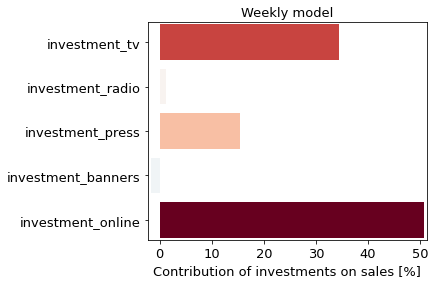

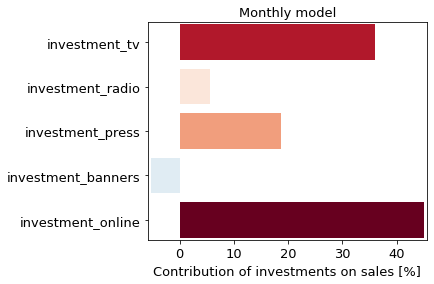

In [35]:
# Marketing channels
channels = ["investment_tv", "investment_radio", "investment_press", "investment_banners", "investment_online"]

# Set dataframe for contributions to sales
contribution_weekly = pd.DataFrame(index=weekly.index)
contribution_monthly = pd.DataFrame(index=monthly.index)

# Calculate and fill dataframe for contributions to sales
for channel in channels:
    channel = channel + '_adsMemory_diminishingReturns'
    contribution_weekly[channel] = model_weekly.params[channel] * weekly[channel]
    contribution_monthly[channel] = model_monthly.params[channel] * monthly[channel]

# Calculate total contribution to sales
total_contibution_weekly = contribution_weekly.sum()
total_contibution_monthly = contribution_monthly.sum()

# Provide relative contribution to sales
relative_contibution_weekly = 100 * total_contibution_weekly / total_contibution_weekly.sum()
relative_contibution_monthly = 100 * total_contibution_monthly / total_contibution_monthly.sum()

plotContributionOrEfficiency(relative_contibution_weekly)
plotContributionOrEfficiency(relative_contibution_monthly, title = "Monthly model")

#### Discussion
It looks the main contribution on sales ~ 50% has invenstment to online, then ~ 35 % has investment to TV, following with ~ 15 % investment to press. Investment to radio is very close zero and investment to radio is negative (it can be interpret as zero with fluctuation of model fit)

#### 11B. Efficiency of marketing channels

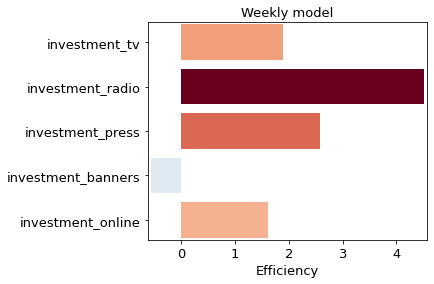

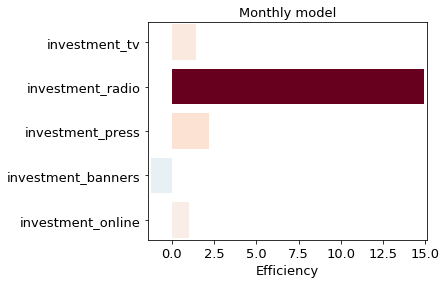

In [36]:
# Estimate total investments in both datasets  
investments_weekly = {
    "investment_tv_adsMemory_diminishingReturns": weekly["investment_tv"].sum(),
    "investment_radio_adsMemory_diminishingReturns": weekly["investment_radio"].sum(),
    "investment_press_adsMemory_diminishingReturns": weekly["investment_press"].sum(),
    "investment_banners_adsMemory_diminishingReturns": weekly["investment_banners"].sum(),
    "investment_online_adsMemory_diminishingReturns": weekly["investment_online"].sum()}

investments_monthly = {
    "investment_tv_adsMemory_diminishingReturns": monthly["investment_tv"].sum(),
    "investment_radio_adsMemory_diminishingReturns": monthly["investment_radio"].sum(),
    "investment_press_adsMemory_diminishingReturns": monthly["investment_press"].sum(),
    "investment_banners_adsMemory_diminishingReturns": monthly["investment_banners"].sum(),
    "investment_online_adsMemory_diminishingReturns": monthly["investment_online"].sum()}

# Estimate efficiency from total contributions and investments  
efficiency_weekly = total_contibution_weekly / pd.Series(investments_weekly)
efficiency_monthly = total_contibution_monthly / pd.Series(investments_monthly)

plotContributionOrEfficiency(efficiency_weekly, label = "Efficiency")
plotContributionOrEfficiency(efficiency_monthly, title = "Monthly model", label = "Efficiency")

#### Discussion
It looks the most efficient is investment to radio more than 4, then investment to press about 2.5, following with investment to TV close to 2. The investment to online is effective about 1.5. The efficinecy of investment to banners is negative, what proving our idea, this channel is not relevant for both contribution in sales and efficiency. 

The funny observation is that contribution in sales has opposite order in compare to efficiency. Would be nice to understand why. 

### 10. What and how to present results to client (SlidesForClient.pdf)
* Describe data preparation and implementation of behavioral findings to model
* Simple statistical, mathematical view to model result
* Show marketing iteresting results

### 12. Finding optimal marketing mix
Firstly, we should provide enough checks to be sure our model is consistent, otherwise we need to set more realistic (optimal) with stable coeficients, efficient and nice explain channel contribution to sales. 
This model then can be optimized. For optimization we need to know what a client what to optimized and what is his constraints. After clear evidence of optimization task we can start look for optimal marketing mix. In principle optimization is looking for maximum or minimum a function which clearly defined a client expectations and constraints.